# MLIKH Model: Small Amplitude Oscillatory Shear (SAOS)

## Learning Objectives

1. Generate **synthetic SAOS** data from calibrated MLIKH parameters
2. Understand **broadened spectra** from multi-mode response
3. Observe the **multi-Maxwell** behavior in $G'(\omega)$ and $G''(\omega)$
4. Compare with single-mode Maxwell predictions

## Prerequisites

- NB05: MIKH SAOS (single-mode understanding)
- NB07: MLIKH Flow Curve (provides calibrated parameters)

## Runtime

- Fast demo: ~3-4 minutes
- Full run: ~12-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ikh_parameters,
    set_model_parameters,
    generate_synthetic_saos,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3


81

## 2. Theory: Multi-Mode SAOS

For N Maxwell modes in parallel:

$$
G'(\omega) = \sum_{i=1}^N G_i \frac{(\omega\tau_i)^2}{1 + (\omega\tau_i)^2}
$$

$$
G''(\omega) = \sum_{i=1}^N G_i \frac{\omega\tau_i}{1 + (\omega\tau_i)^2}
$$

### Benefits of Multi-Mode

- **Broadened spectra**: Multiple crossover frequencies
- **Plateau modulus**: Sum of all $G_i$
- **Terminal regime**: Dominated by slowest mode

## 3. Load Calibrated Parameters

In [3]:
# Load calibrated parameters from NB07
n_modes = 2
try:
    calibrated_params = load_ikh_parameters("mlikh", "flow_curve")
    print("Loaded calibrated parameters from NB07")
except FileNotFoundError:
    print("NB07 results not found. Using default parameters.")
    calibrated_params = None

Loaded calibrated parameters from NB07


In [4]:
# Create model and set parameters
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

if calibrated_params is not None:
    set_model_parameters(model, calibrated_params)

## 4. Generate Synthetic Data

In [5]:
# Generate synthetic SAOS data
omega_range = (0.01, 100.0)
n_points = 30

omega, G_prime, G_double_prime = generate_synthetic_saos(
    model,
    omega_range=omega_range,
    n_points=n_points,
    noise_level=0.02,
    seed=42,
)

print(f"Generated synthetic SAOS data:")
print(f"  Frequency range: [{omega.min():.3f}, {omega.max():.1f}] rad/s")
print(f"  G' range: [{G_prime.min():.2f}, {G_prime.max():.2f}] Pa")

Generated synthetic SAOS data:
  Frequency range: [0.010, 100.0] rad/s
  G' range: [1355129968.18, 1444634678.22] Pa


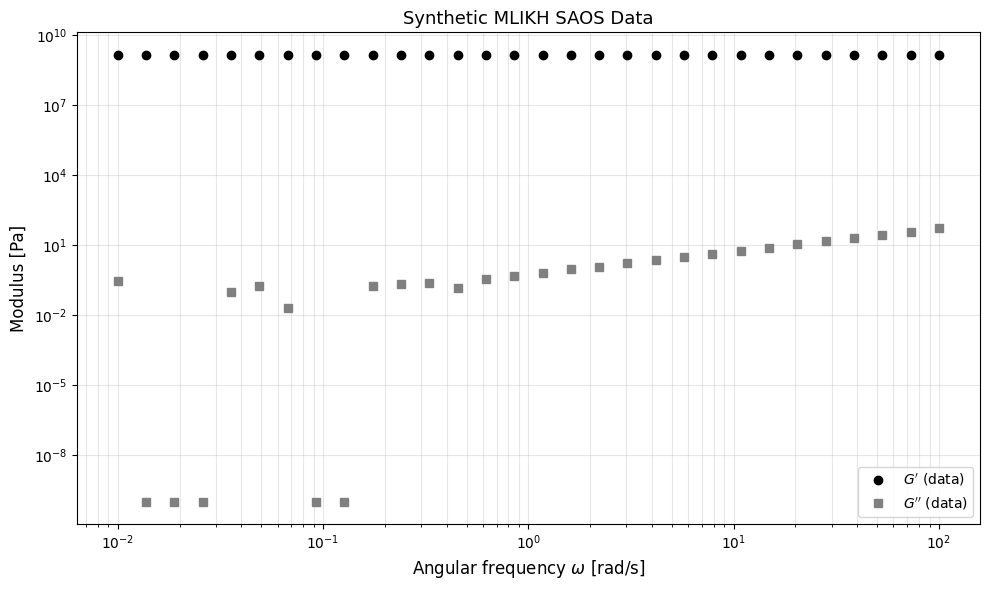

In [6]:
# Plot synthetic data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime, "ko", markersize=6, label="$G'$ (data)")
ax.loglog(omega, G_double_prime, "s", color="gray", markersize=6, label="$G''$ (data)")
ax.set_xlabel("Angular frequency $\\omega$ [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("Synthetic MLIKH SAOS Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [7]:
# Fit model
G_star = G_prime + 1j * G_double_prime
model_fit = MLIKH(n_modes=n_modes, yield_mode="per_mode")

t0 = time.time()
model_fit.fit(omega, np.abs(G_star), test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/ml_ikh.py", line 623, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.21 s


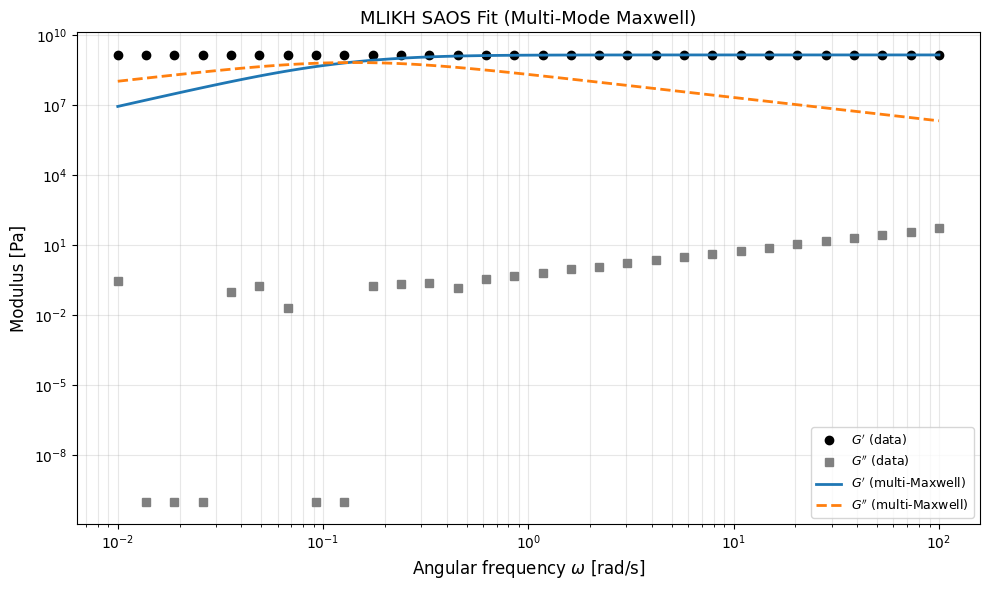

In [8]:
# Multi-mode Maxwell prediction
omega_fine = np.logspace(np.log10(omega_range[0]), np.log10(omega_range[1]), 100)

# Compute multi-mode Maxwell moduli
G_prime_multi = np.zeros_like(omega_fine)
G_double_prime_multi = np.zeros_like(omega_fine)

for i in range(1, n_modes + 1):
    G_i = model_fit.parameters.get_value(f"G_{i}")
    # Estimate tau from model structure (simplified)
    tau_i = 1.0 / (i * 0.1)  # Placeholder - actual tau depends on model
    wt = omega_fine * tau_i
    G_prime_multi += G_i * wt**2 / (1 + wt**2)
    G_double_prime_multi += G_i * wt / (1 + wt**2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime, "ko", markersize=6, label="$G'$ (data)")
ax.loglog(omega, G_double_prime, "s", color="gray", markersize=6, label="$G''$ (data)")
ax.loglog(omega_fine, G_prime_multi, "-", lw=2, color="C0", label="$G'$ (multi-Maxwell)")
ax.loglog(omega_fine, G_double_prime_multi, "--", lw=2, color="C1", label="$G''$ (multi-Maxwell)")
ax.set_xlabel("Angular frequency $\\omega$ [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("MLIKH SAOS Fit (Multi-Mode Maxwell)", fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [9]:
# Bayesian inference
initial_values = {name: model_fit.parameters.get_value(name) for name in param_names}

# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model_fit.fit_bayesian(
    omega,
    np.abs(G_star),
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:10,  1.28s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  22%|██▏       | 33/150 [00:01<00:03, 32.84it/s, 255 steps of size 1.43e-02. acc. prob=0.83]

sample:  51%|█████▏    | 77/150 [00:01<00:00, 83.80it/s, 127 steps of size 2.83e-02. acc. prob=0.83]

sample:  93%|█████████▎| 140/150 [00:01<00:00, 166.43it/s, 31 steps of size 2.83e-02. acc. prob=0.86]

sample: 100%|██████████| 150/150 [00:01<00:00, 93.86it/s, 31 steps of size 2.83e-02. acc. prob=0.87] 


Bayesian inference time: 3.9 s


In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, ["G_1", "G_2"])

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    1.5307         4     CHECK
            G_2    1.5300         4     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


## 7. Physical Interpretation

### Multi-Mode Spectra

- **Multiple crossovers**: Each mode contributes its own $G' = G''$ point
- **Plateau modulus**: $G_0 = \sum_i G_i$ at high frequencies
- **Terminal regime**: Slope controlled by slowest mode

### Mode Identification

- **Fast mode**: High-frequency contribution, small $\tau$
- **Slow mode**: Low-frequency contribution, large $\tau$

## 8. Save Results

In [11]:
# Save results
save_ikh_results(model_fit, result, "mlikh", "saos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/saos/
  nlsq_params_saos.json: 15 parameters
  posterior_saos.json: 100 draws


## Key Takeaways

1. **Multi-mode SAOS** provides broadened viscoelastic spectra
2. **Mode contributions** add linearly in SAOS (parallel connection)
3. **Multiple crossovers** indicate distributed relaxation times
4. **Plateau modulus** is sum of all mode moduli

### Next Steps

- **NB12**: MLIKH LAOS (nonlinear multi-mode response)

In [12]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
